In [1]:
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.interpolate import SmoothBivariateSpline

import sys
sys.path.append("../")

from electronfactors.model.threshold import angle_gap, fit_give

In [2]:
with open("model_cache/9MeV_10app_100ssd.yml", 'r') as file:
    cutout_data = yaml.load(file)

In [3]:
label = np.array([key for key in cutout_data])
book_factor = np.array([item[0] == 'P' for i, item in enumerate(label)])

In [4]:
# custom_label = label[~book_factor]
# custom_label = label[label != 'P3']

custom_label = label

width = np.array([cutout_data[key]['width'] for key in custom_label])
length = np.array([cutout_data[key]['length'] for key in custom_label])
factor = np.array([cutout_data[key]['factor'] for key in custom_label])

In [5]:
# factor[label == 'P3'] = 0.999

In [6]:
def to_eqPonA(width, length):
    ratio = width/length
    eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width
    
    return eqPonA

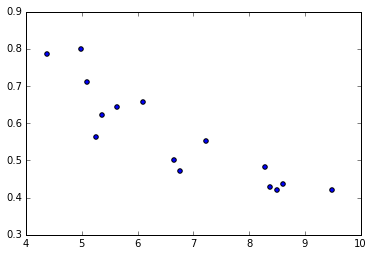

In [7]:
ratio = width/length
eqPonA = 2*(3*(ratio+1) - np.sqrt((3*ratio+1)*(ratio+3))) / width

plt.scatter(width, eqPonA)

In [8]:
# bbox=[min(width),max(width), min(eqPonA),max(eqPonA)]

spline = SmoothBivariateSpline(width,eqPonA,factor,kx=2,ky=1)



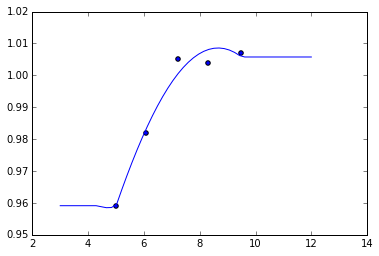

In [9]:
circle_test_width = np.linspace(3,12)
circle_test_eqPonA = to_eqPonA(circle_test_width, circle_test_width)

circle_test_prediction = spline.ev(circle_test_width, circle_test_eqPonA)
plt.plot(circle_test_width, circle_test_prediction)
circle_ref = np.abs(width - length) < 0.1
plt.scatter(width[circle_ref], factor[circle_ref])

In [10]:
x = np.arange(2,14,0.1)
y = x

xx, yy = np.meshgrid(x,y)
   
mesh_width = xx.copy()
mesh_width[xx>yy] = yy[xx>yy]

mesh_length = xx.copy()
mesh_length[yy>xx] = yy[yy>xx]

mesh_ratio = mesh_width / mesh_length

mesh_eqPonA = 2*( 3*(mesh_ratio+1) - np.sqrt( (3*mesh_ratio+1)*(mesh_ratio+3) ) ) / mesh_width

zz = spline.ev(mesh_width, mesh_eqPonA)
give = fit_give(mesh_width, mesh_eqPonA, width, eqPonA, factor, kx=2, ky=1)
gap = angle_gap(mesh_width, mesh_eqPonA, width, eqPonA, 1, 1)

outOfTolerance = (give > 0.5) | (gap > 180)

zz[outOfTolerance] = np.nan
    
zz = np.floor(zz*1e4)/1e4

(0.0, 16.0, 0.0, 16.0)

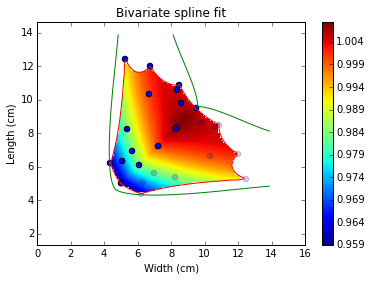

In [11]:
c = plt.contourf(xx,yy,zz,100)
plt.colorbar(c)

plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='r')

plt.scatter(width, length, s=30)
plt.scatter(length, width, s=30, alpha=0.2)

plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
plt.title('Bivariate spline fit')

plt.axis('equal')

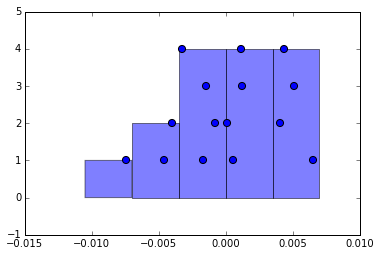

In [12]:
residuals_lengthwidth = factor - spline.ev(width, eqPonA)

binSize = np.floor(4 * residuals_lengthwidth.ptp() / len(residuals_lengthwidth) / 0.0005) * 0.0005
binStart = np.floor(residuals_lengthwidth.min()/binSize)*binSize
binEnd = np.ceil(residuals_lengthwidth.max()/binSize)*binSize

bins = np.arange(binStart,binEnd+binSize,binSize)

dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - residuals_lengthwidth),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):
    binRef = (binNum == i)
    representative_height[binRef] = np.arange(sum(binRef)) + 1

plt.hist(residuals_lengthwidth,bins,alpha=0.5)
plt.scatter(residuals_lengthwidth,representative_height,zorder=2,s=50,)

In [13]:
np.std(residuals_lengthwidth)

0.0037938478572578423

In [14]:
np.argmax(np.abs(residuals_lengthwidth))

10

In [15]:
# label[20]

In [16]:
from scipy.special import gamma

def c4(n):
    
    output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
    if np.isnan(output):
        output = 1
        
    return output

0.00594726625009
-0.000187900925148


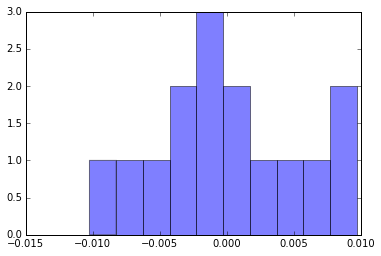

In [17]:
predictionValue = np.zeros(len(custom_label))
# bbox = [
#     min(width) - width.ptp()*0.2,
#     max(width) + width.ptp()*0.2, 
#     min(eqPonA) - eqPonA.ptp()*0.2,
#     max(eqPonA) + eqPonA.ptp()*0.2]

for i in range(len(custom_label)):

    widthTest = np.delete(width, i)
    eqPonATest = np.delete(eqPonA, i)
    factorTest = np.delete(factor, i)

    predictionTestSpline = SmoothBivariateSpline(
        widthTest, eqPonATest, factorTest, kx=2, ky=1)

    predictionValue[i] = predictionTestSpline.ev(width[i],eqPonA[i])


predictionDifference = factor - predictionValue

plt.hist(predictionDifference, alpha=0.5)

predictionStd = np.std(predictionDifference, ddof=1) / c4(len(predictionDifference))

print(predictionStd)
print(np.mean(predictionDifference))

In [18]:
# predictionValue = np.zeros(len(custom_label))
# give = np.zeros(len(custom_label))
# gap = np.zeros(len(custom_label))

# # bbox = [
# #     min(width) - width.ptp()*0.2,
# #     max(width) + width.ptp()*0.2, 
# #     min(eqPonA) - eqPonA.ptp()*0.2,
# #     max(eqPonA) + eqPonA.ptp()*0.2]

# for i in range(len(custom_label)):

#     widthTest = np.delete(width, i)
#     eqPonATest = np.delete(eqPonA, i)
#     factorTest = np.delete(factor, i)

#     predictionTestSpline = SmoothBivariateSpline(
#         widthTest, eqPonATest, factorTest, kx=1, ky=1)

#     predictionValue[i] = predictionTestSpline.ev(width[i],eqPonA[i])
    
#     give[i] = fit_give(width[i], eqPonA[i], widthTest, eqPonATest, factorTest)
#     gap[i] = angle_gap(width[i], eqPonA[i], widthTest, eqPonATest, 1, 1)


# outOfTolerance = (give > 0.5) | (gap > 180)

# predictionDifference = factor[~outOfTolerance] - predictionValue[~outOfTolerance]

# plt.hist(predictionDifference, alpha=0.5)

# predictionStd = np.std(predictionDifference, ddof=1) / c4(len(predictionDifference))

# print(predictionStd)
# print(np.mean(predictionDifference))

In [19]:
# np.argmax(np.abs(predictionDifference))

In [20]:
# label[7]

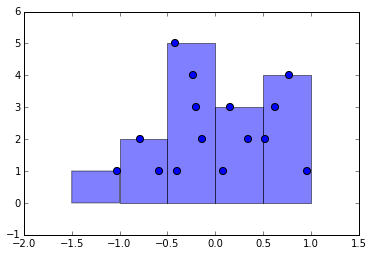

In [21]:
percentDifference = 100*(factor - predictionValue) / factor

binSize = np.floor(4 * percentDifference.ptp() / len(percentDifference) / 0.05) * 0.05
binStart = np.floor(percentDifference.min() / binSize)*binSize
binEnd = np.ceil(percentDifference.max() / binSize)*binSize

bins = np.arange(binStart, binEnd+binSize, binSize)


dbins = bins[1] - bins[0]
binsTrans = bins - dbins/2

binsTrans = binsTrans.reshape(-1,1)
binNum = np.argmin(abs(binsTrans - percentDifference),0)

representative_height = np.zeros(len(binNum))

for i in range(len(bins)):

    binRef = (binNum == i)

    representative_height[binRef] = np.arange(sum(binRef)) + 1


plt.hist(percentDifference,bins,alpha=0.5)
plt.scatter(percentDifference,representative_height,zorder=2,s=50,)

In [22]:
label[np.argsort(np.abs(percentDifference))][::-1]

array(['P34_2', 'Simon 6.7x12cm_9MeV', 'Simon 8.3cm_9MeV',
       'Simon 7.25cm_9MeV', 'P17', 'P8', 'P53', 'P34_3',
       'Simon 5.3x12.5cm_9MeV', 'Simon 9.5cm_9MeV', 'Simon 6.1cm_9MeV',
       'Simon 5cm_9MeV', 'P25', 'P46', 'Simon 8.5x10.9cm_9MeV'], 
      dtype='<U21')

In [23]:
from scipy.stats import shapiro, probplot, ttest_1samp

In [24]:
t, ttestProb = ttest_1samp(percentDifference,0)
res_ttest = "%0.4f" %(ttestProb)

if ttestProb < 0.1:
    tSignificance = 'significant'
else:
    tSignificance = 'not significant'

print('t-Test: ' + res_ttest + ' which is ' + tSignificance)

W, shapiroProb = shapiro(percentDifference)
res_norm = "%0.4f" %(shapiroProb)

if shapiroProb < 0.1:
    shSignificance = 'significant'
else:
    shSignificance = 'not significant'

print('Shapiro: ' + res_norm + ' which is ' + shSignificance)



residualStd = np.std(percentDifference,ddof=1) / c4(len(percentDifference))

res_std = "%0.2f" %(residualStd)
print('Standard deviation with bias correction: ' + res_std)

res_mean = "%0.2f" %(np.mean(percentDifference))
print('Mean:' + res_mean)

t-Test: 0.8880 which is not significant
Shapiro: 0.9632 which is not significant
Standard deviation with bias correction: 0.60
Mean:-0.02


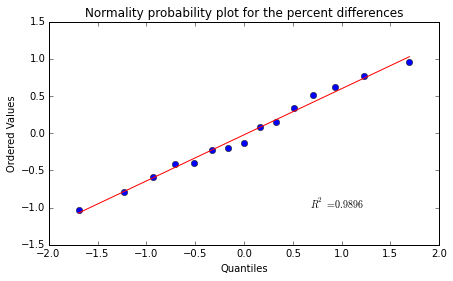

In [25]:
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)

probplot(percentDifference, plot=ax);

ax.set_title("Normality probability plot for the percent differences")

In [26]:
predictions = spline.ev(width, eqPonA)

numTrials = 5000

resampleSpline = [0,]*numTrials
resampledPredictions = np.zeros(np.shape(mesh_width) + (numTrials,))

for i in range(numTrials):

    resample = np.random.normal(loc=predictions, scale=predictionStd)
    resampleSpline[i] = SmoothBivariateSpline(width, eqPonA, resample, kx=2, ky=1)

    resampledPredictions[:,:,i] = resampleSpline[i].ev(mesh_width, mesh_eqPonA)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


(0.0, 16.0, 0.0, 16.0)

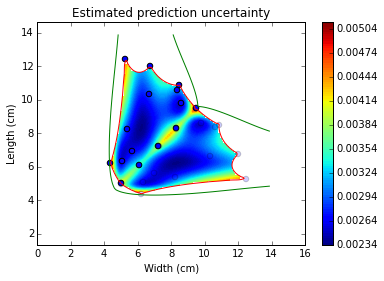

In [27]:
variableUncertaintyEstimate = np.std(resampledPredictions, ddof=1, axis=2) / c4(numTrials)

variableUncertaintyEstimate[outOfTolerance] = np.nan

c = plt.contourf(xx, yy, variableUncertaintyEstimate, 100)
plt.colorbar(c)

plt.contour(xx, yy, give, levels=[0.5], colors='g')
plt.contour(xx, yy, gap, levels=[180], colors='r')

plt.scatter(width,length,s=30)
plt.scatter(length,width,s=30,alpha=0.2)

plt.xlabel('Width (cm)')
plt.ylabel('Length (cm)')
plt.title('Estimated prediction uncertainty')

plt.axis('equal')

In [28]:
from scipy.optimize import basinhopping

class constant_uncertainty(object):
    """Find the constant uncertainty throughout the fit.
    """
    def __init__(self, n=5, debug=False, **kwargs):
        
        self.debug=debug
        
        self.residuals = kwargs['residuals']
        self.variableUncertainty = kwargs['variableUncertainty']

                
        self.basinRequiredSuccess = n
        self.constantUncertainty = np.abs(self.uncertainty_basinhopping())
        
        self.totalUncertainty = np.sqrt(self.variableUncertainty**2 + 
                                        self.constantUncertainty**2)
        

    def c4(n):
    
        output = np.sqrt(2/(n-1)) * gamma(n/2) / gamma((n-1)/2)
        if np.isnan(output):
            output = 1

        return output
    
    
    def minimise_function(self, constantUncertaintyGuess):

        totalUncertaintyGuess = np.sqrt(self.variableUncertainty**2 + constantUncertaintyGuess**2)

        scaled = self.residuals / totalUncertaintyGuess

        scaledStd = np.std(scaled,ddof=1) / c4(len(scaled))
        
        return (scaledStd - 1)**2
        
    
    def uncertainty_basinhopping(self):

        self.functionReturns = np.empty(self.basinRequiredSuccess)
        self.functionReturns[:] = np.nan
        
        self.numSuccess = 0
        
        minimizerConfig = {"method": 'BFGS'}
        
        initial_input = np.array([0.01])
        
        
        basinhoppingOutput = basinhopping(self.minimise_function,
                                          initial_input,
                                          niter=1000,
                                          minimizer_kwargs=minimizerConfig,
                                          take_step=self.step_function,
                                          callback=self.callback_function)
        
        return basinhoppingOutput.x
        
        
    def step_function(self,optimiserInput):

        optimiserInput[0] += np.random.normal(scale=0.01)   # x-position
        
        return optimiserInput
    
    
    def callback_function(self, optimiserOutput, minimiseFunctionOutput, minimiseAccepted):
       
        if self.debug:
            print(optimiserOutput)
            print(minimiseFunctionOutput)
            print(minimiseAccepted)
            print(" ")
        
        if minimiseAccepted:
            
            if self.numSuccess == 0:
                # First result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) + 0.0001:
                # Reject result
                0
                
            elif minimiseFunctionOutput >= np.nanmin(self.functionReturns) - 0.0001:
                # Agreeing result
                self.functionReturns[self.numSuccess] = minimiseFunctionOutput
                self.numSuccess += 1
            
            elif minimiseFunctionOutput < np.nanmin(self.functionReturns) - 0.0001:
                # New result
                self.functionReturns[0] = minimiseFunctionOutput
                self.numSuccess = 1
        
        if self.numSuccess >= self.basinRequiredSuccess:
            return True
        

In [29]:
resampledPredictionsAtPoints = np.zeros(np.shape(width) + (numTrials,))

for i in range(numTrials):

    resampledPredictionsAtPoints[:,i] = resampleSpline[i].ev(width,eqPonA)

fittingUncertainty = np.std(resampledPredictionsAtPoints, ddof=1, axis=1) / c4(numTrials)
# fittingUncertainty

measuredUncertaintyEstimate = constant_uncertainty(residuals=predictionDifference, 
                                                   variableUncertainty=fittingUncertainty)

measuredUncertaintyEstimate.constantUncertainty

measuredUncertaintyString = '%0.2f%%' %(measuredUncertaintyEstimate.constantUncertainty*100)
print(measuredUncertaintyString)

0.49%


/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


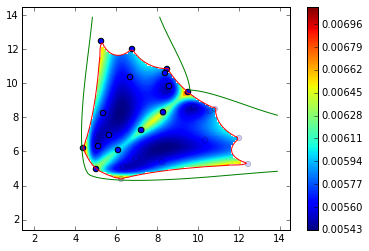

In [30]:
totalUncertaintyEstimate = np.sqrt(variableUncertaintyEstimate**2 + 
                                   measuredUncertaintyEstimate.constantUncertainty**2)

totalUncertaintyEstimate = np.around(totalUncertaintyEstimate,decimals=5)

c = plt.contourf(xx,yy,totalUncertaintyEstimate,200)
plt.colorbar(c)

plt.contour(xx,yy,give,levels=[0.5],colors='g')
plt.contour(xx,yy,gap,levels=[180],colors='r')

plt.scatter(width,length,s=30)
plt.scatter(length,width,s=30,alpha=0.2)